In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import torch
from torch import nn
import torch
import time
from swyft.deps import UNet

import swyft
import pylab as plt
import scipy.stats.distributions as dist

torch.set_float32_matmul_precision('medium')
DEVICE = "cuda"

### Generative model

In [2]:
class SimulatorBlob(swyft.Simulator):
    def __init__(self, bounds = None, Npix = 64, sigma = 0.1):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.theta_sampler = swyft.RectBoundSampler([dist.uniform(3.5, 1.00)])
        self.bounds = bounds
        self.Npix = Npix
        self.sigma = sigma
        self.powersampler = swyft.utils.PowerSpectrumSampler(Npix)
        self.sigma = torch.ones(Npix, Npix)*0.1
#        self.sigma[:,:Npix//2] *= 1000

    def get_pk_fn(self, theta):
        return lambda k: 1e6*3*(k/0.5+1)**-theta[0]
        
    def sample_delta(self, pk_fn):
        if self.bounds is not None:
            i = np.random.randint(len(self.bounds))
            return torch.tensor(self.bounds[i])
        else:
#            return self.powersampler.sample(lambda k: 1e6*3*(k/0.5)**-theta[0])
            return self.powersampler.sample(pk_fn)

    def psf(self, rho):
        return rho
            
    def build(self, graph):
        theta = graph.node("theta", self.theta_sampler)
        pk_fn = graph.node("pk_fn", self.get_pk_fn, theta)
        delta = graph.node("delta", self.sample_delta, pk_fn)
        rho = graph.node("rho", lambda delta: torch.exp(delta/5), delta)
        x = graph.node("x", lambda rho: self.psf(rho) + torch.randn(self.Npix, self.Npix)*self.sigma, rho)
#        z = graph.node("test", lambda: lambda x: x)

In [3]:
NPIX = 64
sim = SimulatorBlob(Npix = NPIX)
sample0 = sim.sample(conditions = dict(theta = np.array([4.])))

/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Inference network

In [4]:
class Network(swyft.SwyftModule):
    def __init__(self, lr=1e-3, N = 1024):
        super().__init__()
        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-4, lrs_factor=0.1, lrs_patience=3)
        self.N = N
        L = lambda x: x*0
        self.Phi = lambda x: x
        self.PhiT = lambda x: x
        self.lre = swyft.LogRatioEstimator_Gaussian_Autoregressive_X_module_based(
            self.N**2, "mu", Phi = self.Phi, PhiT = self.PhiT, L = L, minstd = 1e-5, momentum=0.02)
        self.unet = UNet(1, 1, hidden_channels = 4)
    
    def embed(self, x):
        x = self.unet(x.unsqueeze(1)).squeeze(1) + x
        x = x.view(-1, self.N**2)
        return x

    def forward(self, A, B):
        N = self.N
        rhoA = self.embed(A['x'])
        rhoB = self.embed(B['x'])
        deltaB = B['delta'].view(-1, N**2)
        result = self.lre(rhoA, rhoB, deltaB)
        return result

### Inference

In [5]:
def round(bounds = None, max_epochs = 5, n_sims = 1000, gamma = 0.1, n_draws = 200, slope =4.):
    sim = SimulatorBlob(Npix = NPIX, bounds = bounds)
    samples = sim.sample(n_sims, exclude = ['pk_fn'])
    #net.cpu(); net.float()
    dm = swyft.SwyftDataModule(samples, fractions = [0.9, 0.1, 0.0], batch_size = 64)
    net = Network(N = NPIX)
    trainer = swyft.SwyftTrainer(accelerator = "gpu", devices = 1, max_epochs = max_epochs)
    trainer.fit(net, dm)
    
    GAMMA = gamma # 0.1 # 0.0001
    
    x = sample0['x']
    y = net.cuda().double().embed(torch.tensor(x).cuda().double().unsqueeze(0))[0]
    pk = SimulatorBlob(Npix = NPIX).sample(conditions = dict(theta = np.array([slope])))['pk_fn']
    prior = sim.powersampler.get_prior_Q_factors(pk)
    prior = (prior[0], prior[1].cuda(), prior[2])
    x0 = net.lre.get_MAP(y, prior, gamma = GAMMA)
    
    draws = net.lre.get_noise_samples_GEDA(n_draws, prior, steps = 300, reset = True, gamma = GAMMA)
    
    bounds = [(x0.view(NPIX, NPIX).cpu().detach() + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
    bounds = np.array(bounds)
    
    v = 15
    plt.figure(figsize = (15, 5))
    for i in range(4):
        plt.subplot(2, 4, i+1)
        if i == 0:
            plt.imshow(sample0['delta'], cmap = 'seismic', vmin = -v, vmax = v)
        else:
            plt.imshow(bounds[i], vmin = -v, vmax = v, cmap = 'seismic')
        plt.colorbar()    
    res = [(x0.view(NPIX, NPIX).cpu().detach()*0 + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
    for i in range(4):
        plt.subplot(2, 4, i+1+4)
        plt.imshow(res[i], vmin = -v, vmax = v, cmap = 'seismic')
        plt.colorbar()
    plt.show()

    x = sample0['delta'].flatten()
    y = bounds.reshape(-1, NPIX**2)
    ym = y.mean(axis=0)
    ys = y.std(axis=0)
    plt.scatter(x, ym)
    plt.scatter(x, x)
    plt.show()

    diff = ((y-x)/ys).flatten()
    plt.hist(diff, bins = 100)
    plt.show()
    p = np.percentile(diff, [2.5, 16, 50, 84, 97.5])
    print("Residual percentiles:", p)

    pks = swyft.utils.get_pk(torch.tensor(bounds))
    clean_sims = SimulatorBlob().sample(100)['delta']
    pks2 = swyft.utils.get_pk(torch.tensor(clean_sims))
    pks3 = swyft.utils.get_pk(torch.tensor(sample0['delta']))
    plt.plot([], '0.5', alpha = 0.5, label = "Unconstrained")
    plt.plot([], 'r', alpha = 0.5, label = "Constrained")
    plt.semilogy(pks2.T, '0.5', alpha = 0.5);
    plt.semilogy(pks.T, 'r', alpha = 0.5);
    plt.semilogy(pks3.T, 'y', label = "Truth");
    plt.legend()
    plt.show()

    return bounds

In [6]:
bounds = None
bounds = round(bounds = bounds, max_epochs = 15, n_draws = 300, gamma = 1e-1)

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/weniger/.conda/envs/lensing/lib/python3.9/site ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /gpfs/home2/weniger/swyft/notebooks/dev/lightning_logs/version_3224651/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                                                     | Params
-----

Sanity Checking: 0it [00:00, ?it/s]

/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (15) is smaller tha

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


KeyboardInterrupt: 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2982.08it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                                                     | Params
----------------------------------------------------------------------------------
0 | lre  | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
1 | unet | UNet                                                     | 1.9 M 
----------------------------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.769     Total estimated model params size (MB)


Epoch 0:  88%|████████████████████████████████████████████████████████████████████████████████████████████████▏            | 15/17 [00:00<00:00, 15.65it/s, loss=1.29e+04, v_num=79]
Validation: 0it [00:00, ?it/s]
Epoch 1:  88%|███████████████████████████████████████████████████████████████████████████████████▊           | 15/17 [00:00<00:00, 17.54it/s, loss=631, v_num=79, val_loss=-1.67e+3]
Validation: 0it [00:00, ?it/s]
Epoch 2:  88%|█████████████████████████████████████████████████████████████████████████████████████▌           | 15/17 [00:00<00:00, 16.65it/s, loss=-999, v_num=79, val_loss=-816.]
Validation: 0it [00:00, ?it/s]
Epoch 3:  88%|██████████████████████████████████████████████████████████████████████████████▌          | 15/17 [00:00<00:00, 16.74it/s, loss=-1.45e+03, v_num=79, val_loss=-1.28e+3]
Validation: 0it [00:00, ?it/s]
Epoch 4:  88%|██████████████████████████████████████████████████████████████████████████████▌          | 15/17 [00:00<00:00, 17.55it/s, loss=-1.68e+03, 

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 15.88it/s, loss=-2.51e+03, v_num=79, val_loss=-2.51e+3]


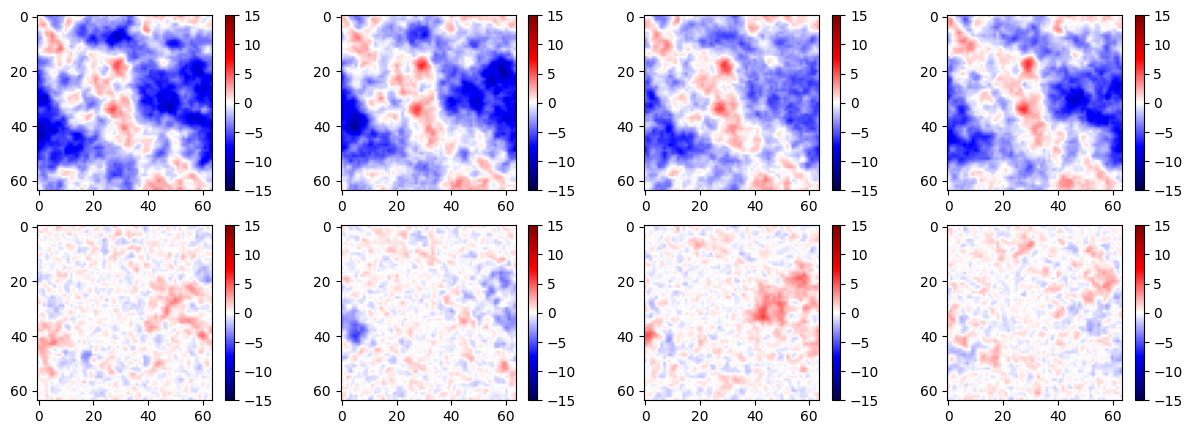

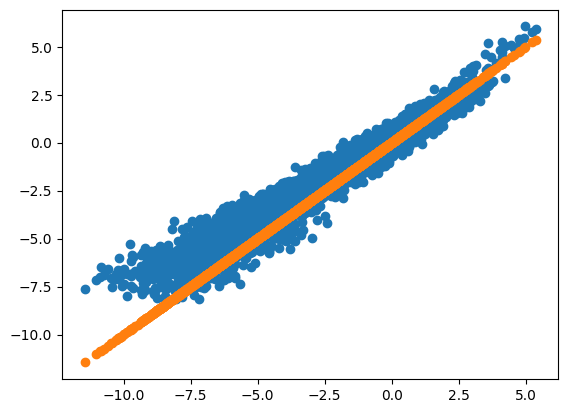

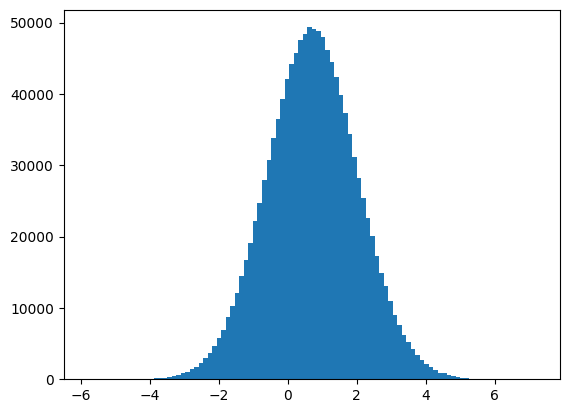

Residual percentiles: [-1.84599448 -0.58769295  0.70883444  2.01281342  3.30873934]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1752.13it/s]


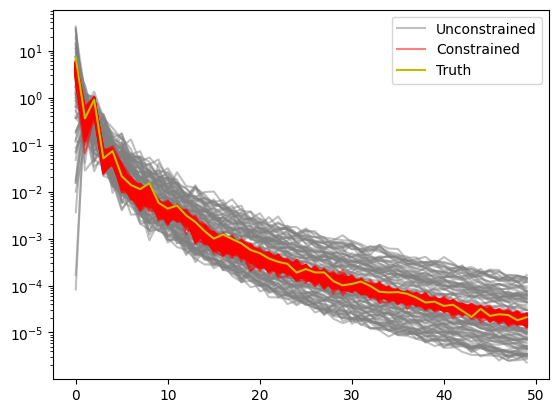

In [12]:
bounds = round(bounds = bounds, max_epochs = 15, n_draws = 300, gamma = 1e-1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3625.80it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                                                     | Params
----------------------------------------------------------------------------------
0 | lre  | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
1 | unet | UNet                                                     | 1.9 M 
----------------------------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.769     Total estimated model params size (MB)


Epoch 0:  88%|████████████████████████████████████████████████████████████████████████████████████████████████▏            | 15/17 [00:00<00:00, 16.70it/s, loss=4.28e+03, v_num=80]
Validation: 0it [00:00, ?it/s]
Epoch 1:  88%|██████████████████████████████████████████████████████████████████████████████████▉           | 15/17 [00:00<00:00, 16.66it/s, loss=-385, v_num=80, val_loss=-1.04e+3]
Validation: 0it [00:00, ?it/s]
Epoch 2:  88%|█████████████████████████████████████████████████████████████████████████████████████▌           | 15/17 [00:00<00:00, 17.05it/s, loss=-975, v_num=80, val_loss=-937.]
Validation: 0it [00:00, ?it/s]
Epoch 3:  88%|██████████████████████████████████████████████████████████████████████████████▌          | 15/17 [00:00<00:00, 17.93it/s, loss=-1.16e+03, v_num=80, val_loss=-1.14e+3]
Validation: 0it [00:00, ?it/s]
Epoch 4:  88%|██████████████████████████████████████████████████████████████████████████████▌          | 15/17 [00:00<00:00, 16.90it/s, loss=-1.28e+03, 

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 15.86it/s, loss=-1.97e+03, v_num=80, val_loss=-2.01e+3]


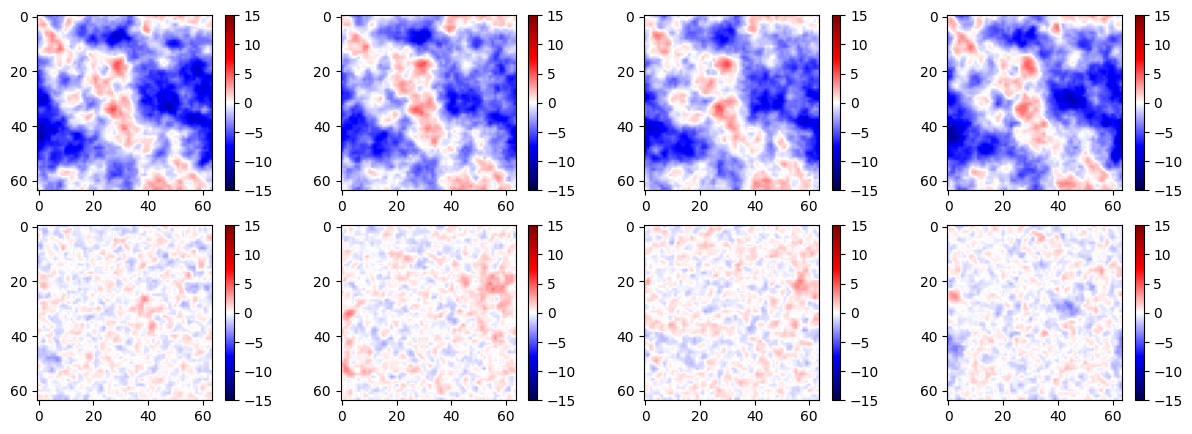

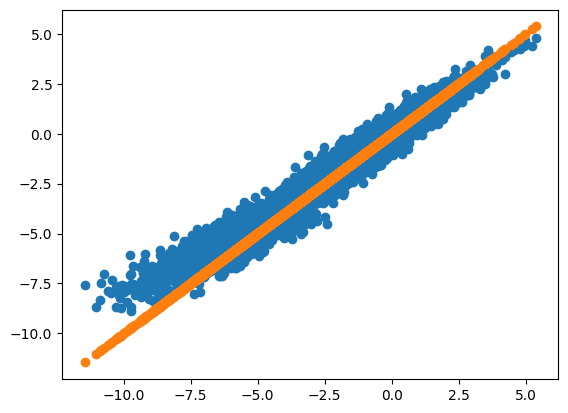

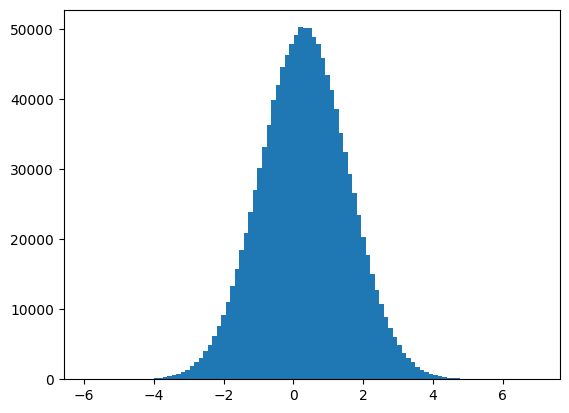

Residual percentiles: [-2.13194086 -0.93493149  0.31221114  1.56593413  2.78073636]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2011.61it/s]


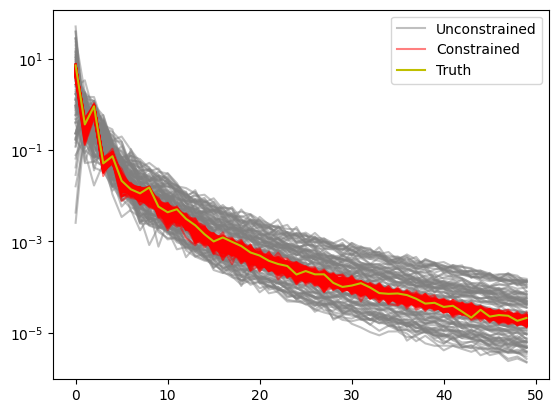

In [13]:
bounds = round(bounds = bounds, max_epochs = 15, n_draws = 300, gamma = 1e-1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2963.88it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                                                     | Params
----------------------------------------------------------------------------------
0 | lre  | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
1 | unet | UNet                                                     | 1.9 M 
----------------------------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.769     Total estimated model params size (MB)


Epoch 0:  88%|████████████████████████████████████████████████████████████████████████████████████████████████▏            | 15/17 [00:00<00:00, 17.63it/s, loss=9.45e+03, v_num=81]
Validation: 0it [00:00, ?it/s]
Epoch 1:  88%|██████████████████████████████████████████████████████████████████████████████████████▍           | 15/17 [00:00<00:00, 17.51it/s, loss=583, v_num=81, val_loss=-37.9]
Validation: 0it [00:00, ?it/s]
Epoch 2:  88%|█████████████████████████████████████████████████████████████████████████████████████▌           | 15/17 [00:00<00:00, 17.96it/s, loss=-550, v_num=81, val_loss=-360.]
Validation: 0it [00:00, ?it/s]
Epoch 3:  88%|█████████████████████████████████████████████████████████████████████████████████████▌           | 15/17 [00:00<00:00, 16.99it/s, loss=-884, v_num=81, val_loss=-771.]
Validation: 0it [00:00, ?it/s]
Epoch 4:  88%|█████████████████████████████████████████████████████████████████████████████████▏          | 15/17 [00:00<00:00, 18.22it/s, loss=-1.07e+0

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 16.16it/s, loss=-2.02e+03, v_num=81, val_loss=-2.03e+3]


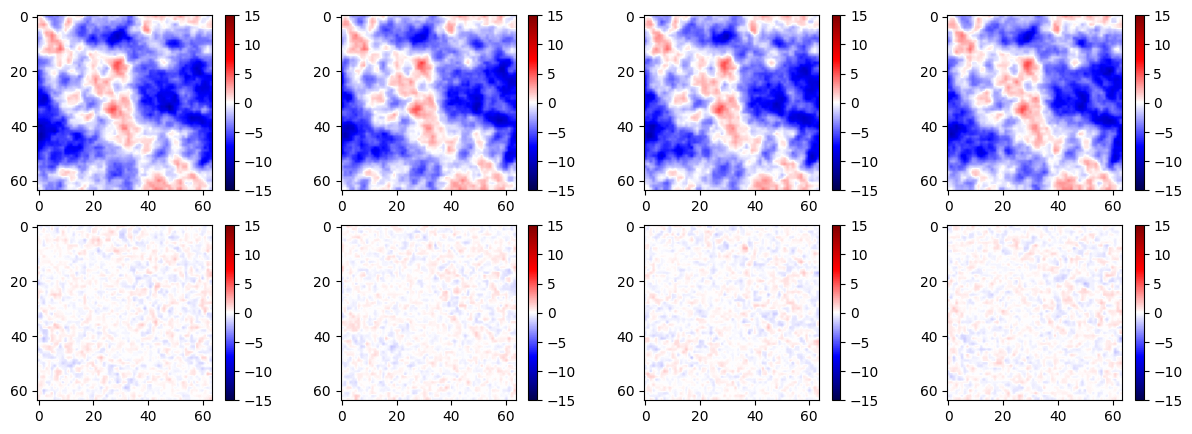

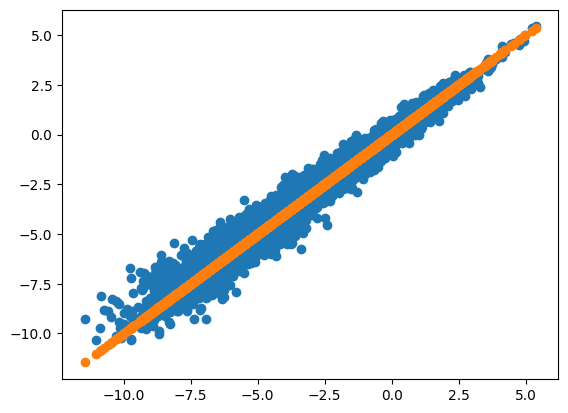

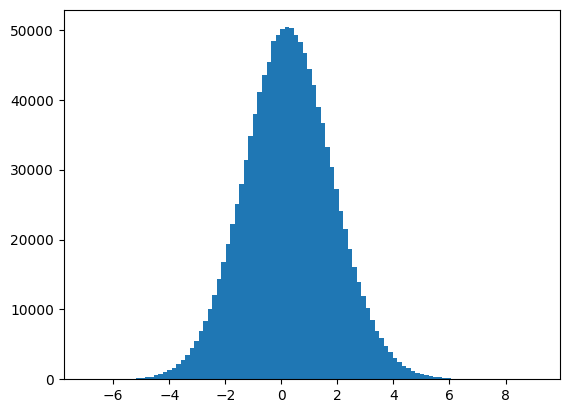

Residual percentiles: [-2.8076757  -1.28907044  0.25556142  1.83743372  3.44702983]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1543.80it/s]


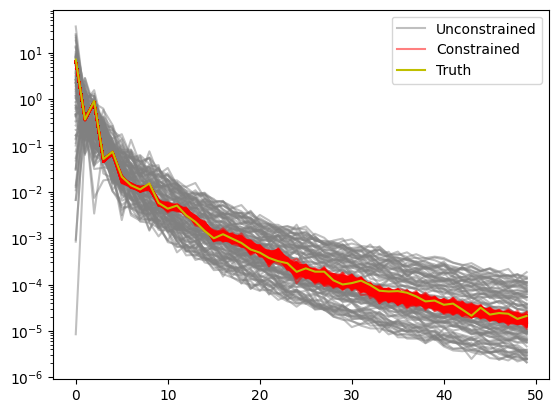

In [14]:
bounds = round(bounds = bounds, max_epochs = 15, n_draws = 300, gamma = 1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3420.86it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                                                     | Params
----------------------------------------------------------------------------------
0 | lre  | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
1 | unet | UNet                                                     | 1.9 M 
----------------------------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.769     Total estimated model params size (MB)


Epoch 0:  88%|████████████████████████████████████████████████████████████████████████████████████████████████▏            | 15/17 [00:00<00:00, 15.77it/s, loss=1.77e+03, v_num=82]
Validation: 0it [00:00, ?it/s]
Epoch 1:  88%|████████████████████████████████████████████████████████████████████████████████████▋           | 15/17 [00:00<00:00, 17.59it/s, loss=-41.6, v_num=82, val_loss=-352.]
Validation: 0it [00:00, ?it/s]
Epoch 2:  88%|█████████████████████████████████████████████████████████████████████████████████████▌           | 15/17 [00:00<00:00, 17.37it/s, loss=-283, v_num=82, val_loss=-256.]
Validation: 0it [00:00, ?it/s]
Epoch 3:  88%|█████████████████████████████████████████████████████████████████████████████████████▌           | 15/17 [00:00<00:00, 17.27it/s, loss=-358, v_num=82, val_loss=-317.]
Validation: 0it [00:00, ?it/s]
Epoch 4:  88%|█████████████████████████████████████████████████████████████████████████████████████▌           | 15/17 [00:00<00:00, 16.47it/s, loss=-40

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.81it/s, loss=-626, v_num=82, val_loss=-562.]


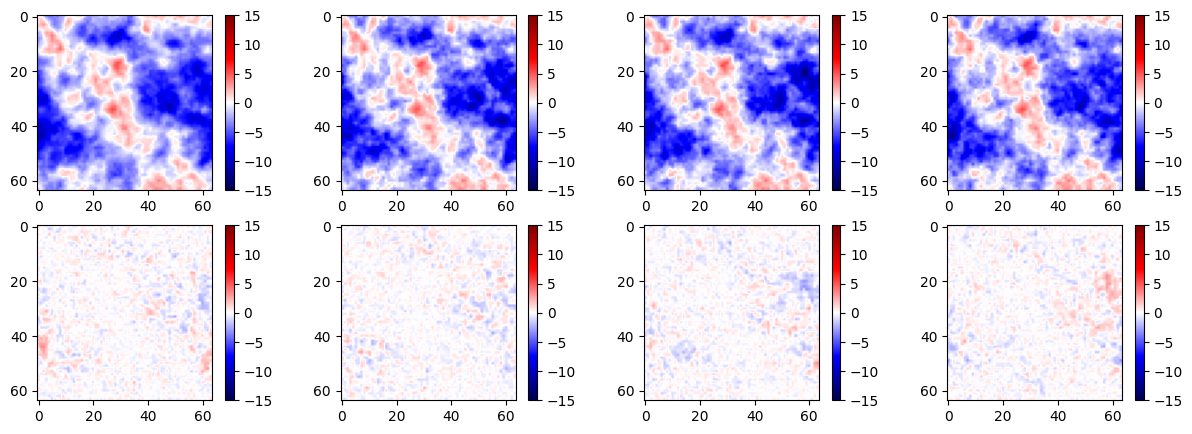

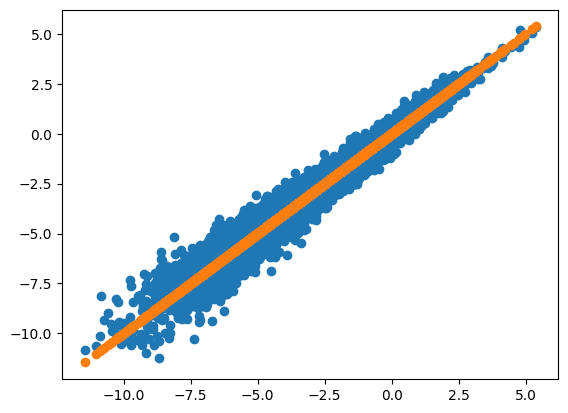

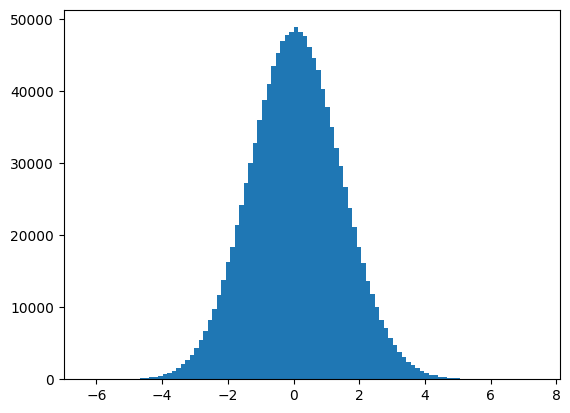

Residual percentiles: [-2.61087967 -1.30419697  0.06239982  1.45057579  2.82374448]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2034.35it/s]


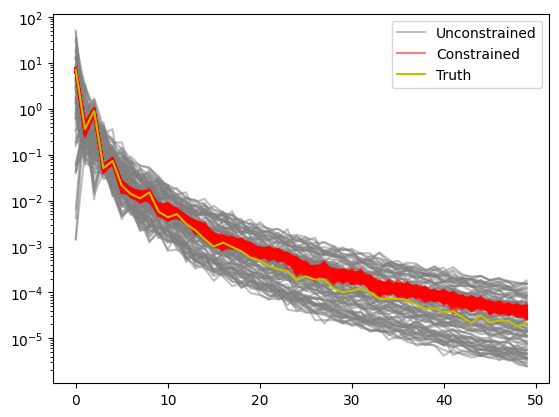

In [17]:
bounds = round(bounds = bounds, max_epochs = 15, n_draws = 300, gamma = 1, slope = 3.5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3299.05it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                                                     | Params
----------------------------------------------------------------------------------
0 | lre  | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
1 | unet | UNet                                                     | 1.9 M 
----------------------------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.769     Total estimated model params size (MB)


Epoch 0:  88%|████████████████████████████████████████████████████████████████████████████████████████████████▏            | 15/17 [00:00<00:00, 18.07it/s, loss=2.37e+03, v_num=83]
Validation: 0it [00:00, ?it/s]
Epoch 1:  88%|█████████████████████████████████████████████████████████████████████████████████████▌           | 15/17 [00:00<00:00, 17.12it/s, loss=13.2, v_num=83, val_loss=-562.]
Validation: 0it [00:00, ?it/s]
Epoch 2:  88%|█████████████████████████████████████████████████████████████████████████████████████▌           | 15/17 [00:00<00:00, 16.10it/s, loss=-363, v_num=83, val_loss=-333.]
Validation: 0it [00:00, ?it/s]
Epoch 3:  88%|█████████████████████████████████████████████████████████████████████████████████████▌           | 15/17 [00:00<00:00, 17.81it/s, loss=-478, v_num=83, val_loss=-422.]
Validation: 0it [00:00, ?it/s]
Epoch 4:  88%|█████████████████████████████████████████████████████████████████████████████████████▌           | 15/17 [00:00<00:00, 16.04it/s, loss=-54

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 16.81it/s, loss=-663, v_num=83, val_loss=-633.]


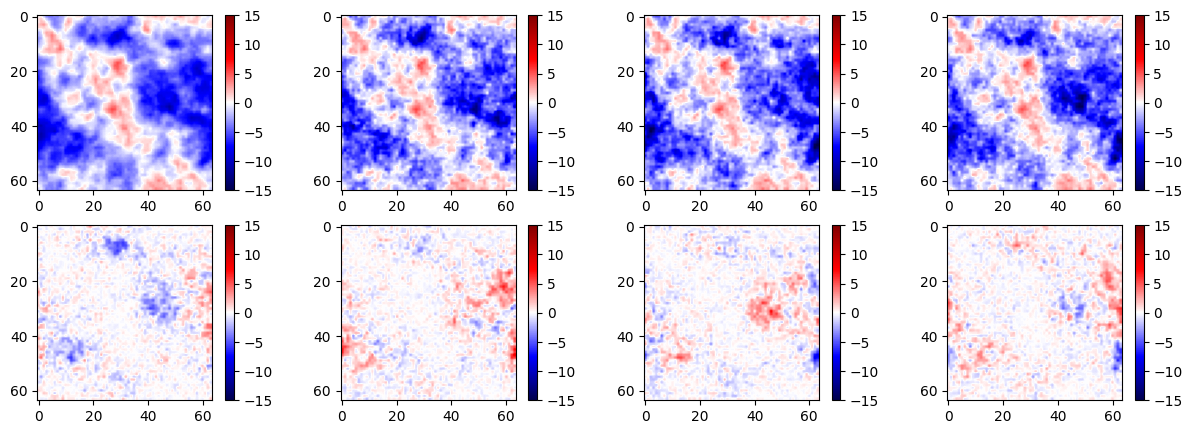

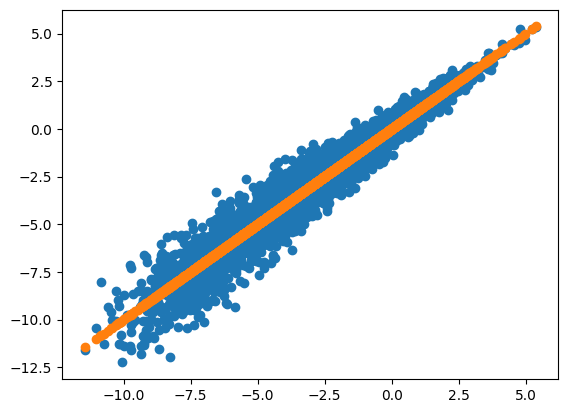

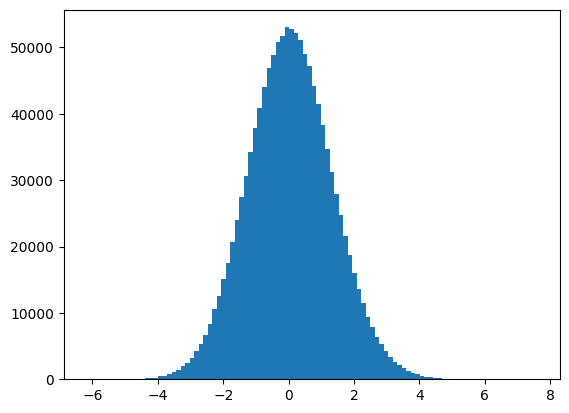

Residual percentiles: [-2.43743517 -1.22512784  0.03862831  1.32563565  2.63369512]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1830.14it/s]


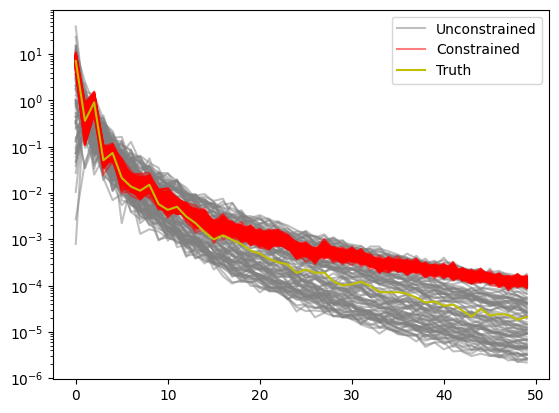

In [18]:
bounds = round(bounds = bounds, max_epochs = 15, n_draws = 300, gamma = 1, slope = 3.5)